#Team members (SRN)
Anagha H M (PES1UG19CS057)

Hanuraag R Bhaskaran (PES1UG19CS177)

Justin James (PES1UG19CS198)

The aim of this notebook is to implement music genre classification. 
This can be split into 3 parts:
  - Using ANN
  - Overcoming overfitting
  - Using CNN

The GTZAN dataset is read using librosa library which only read files <1Mb. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [ ]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset_path = r"/content/drive/MyDrive/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length 
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)

In [ ]:
from IPython.display import clear_output

In [ ]:
save_mfcc(dataset_path,json_path,num_segments=10)
#clear_output()

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/genres_original/hiphop/hiphop.00099.wav, segment: 5
/content/drive/MyDrive/genres_original/hiphop/hiphop.00099.wav, segment: 6
/content/drive/MyDrive/genres_original/hiphop/hiphop.00099.wav, segment: 7
/content/drive/MyDrive/genres_original/hiphop/hiphop.00099.wav, segment: 8
/content/drive/MyDrive/genres_original/hiphop/hiphop.00099.wav, segment: 9
/content/drive/MyDrive/genres_original/hiphop/hiphop.00099.wav, segment: 10
Processing: rock
/content/drive/MyDrive/genres_original/rock/rock.00001.wav, segment: 1
/content/drive/MyDrive/genres_original/rock/rock.00001.wav, segment: 2
/content/drive/MyDrive/genres_original/rock/rock.00001.wav, segment: 3
/content/drive/MyDrive/genres_original/rock/rock.00001.wav, segment: 4
/content/drive/MyDrive/genres_original/rock/rock.00001.wav, segment: 5
/content/drive/MyDrive/genres_original/rock/rock.00001.wav, segment: 6
/content/drive/MyDrive/genres_original/rock/rock.00001.

In [ ]:
filepath = r"/content/drive/MyDrive/genres_original/blues/blues.0000"

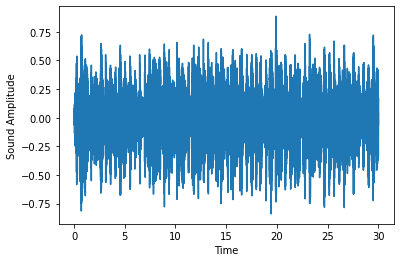

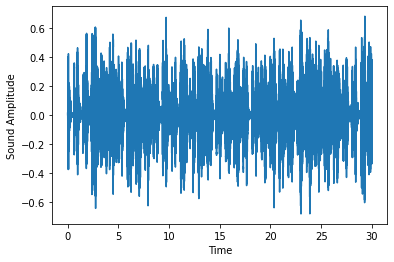

In [ ]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Classifier
This part uses the concepts of ANN with keras and sequential layers. The dataset is split in a 70:30 ratio

The model is Sequential and the architecture contains Flatten and the Dense layers available in keras for the basic ANN representation. As it is a naive model we can expect it to be overfit.

In [ ]:
import json
import numpy as np

In [ ]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs,targets

In [ ]:
inputs,targets = load_data(r"./data.json")

In [ ]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

Epoch 1/50
219/219 [==============================] - 4s 13ms/step - loss: 5.6389 - accuracy: 0.2468 - val_loss: 2.1354 - val_accuracy: 0.2427
Epoch 2/50
219/219 [==============================] - 3s 12ms/step - loss: 2.0200 - accuracy: 0.2927 - val_loss: 2.0680 - val_accuracy: 0.2971
Epoch 3/50
219/219 [==============================] - 3s 12ms/step - loss: 1.8972 - accuracy: 0.3308 - val_loss: 2.0287 - val_accuracy: 0.2850
Epoch 4/50
219/219 [==============================] - 3s 12ms/step - loss: 1.8046 - accuracy: 0.3637 - val_loss: 2.0228 - val_accuracy: 0.3301
Epoch 5/50
219/219 [==============================] - 3s 12ms/step - loss: 1.7579 - accuracy: 0.3877 - val_loss: 2.0151 - val_accuracy: 0.3718
Epoch 6/50
219/219 [==============================] - 3s 12ms/step - loss: 1.6644 - accuracy: 0.4262 - val_loss: 1.9786 - val_accuracy: 0.3695
Epoch 7/50
219/219 [==============================] - 3s 13ms/step - loss: 1.6104 - accuracy: 0.4494 - val_loss: 1.9611 - val_accuracy: 0.3818

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

<Figure size 1440x1080 with 0 Axes>

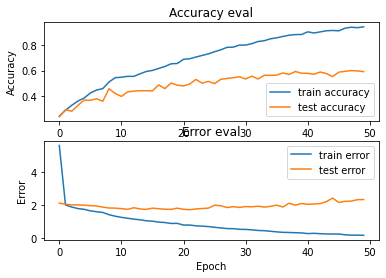

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 1s 8ms/step - loss: 2.3516 - accuracy: 0.5918
Test accuracy: 0.5917890667915344


# Overfitting
This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.
- Making architecture less complicated 
- Using augmented data
- Early stopping of training
- Adding dropout layers
- Regularization / Standardization  

Dropout layers and kernel_regularizers are added. The dropout probability is 30%
Kerneal_regulaizers are used to impose penalties

In [ ]:
import tensorflow.keras as keras

In [ ]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1690)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)


Epoch 1/50
219/219 [==============================] - 6s 23ms/step - loss: 10.3704 - accuracy: 0.1100 - val_loss: 4.9575 - val_accuracy: 0.1078
Epoch 2/50
219/219 [==============================] - 5s 22ms/step - loss: 5.1226 - accuracy: 0.1153 - val_loss: 4.8693 - val_accuracy: 0.1288
Epoch 3/50
219/219 [==============================] - 5s 23ms/step - loss: 4.9790 - accuracy: 0.1235 - val_loss: 4.7913 - val_accuracy: 0.1439
Epoch 4/50
219/219 [==============================] - 5s 23ms/step - loss: 4.8615 - accuracy: 0.1323 - val_loss: 4.7218 - val_accuracy: 0.1495
Epoch 5/50
219/219 [==============================] - 6s 28ms/step - loss: 4.7889 - accuracy: 0.1366 - val_loss: 4.6612 - val_accuracy: 0.1539
Epoch 6/50
219/219 [==============================] - 6s 28ms/step - loss: 4.6970 - accuracy: 0.1455 - val_loss: 4.5825 - val_accuracy: 0.1726
Epoch 7/50
219/219 [==============================] - 6s 26ms/step - loss: 4.6224 - accuracy: 0.1621 - val_loss: 4.5092 - val_accuracy: 0.180

<Figure size 1440x1080 with 0 Axes>

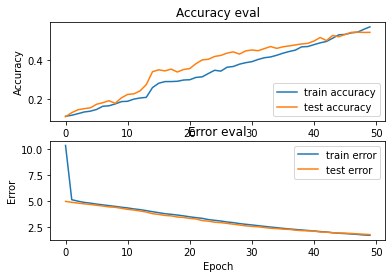

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 5ms/step - loss: 1.7475 - accuracy: 0.5461
Test accuracy: 0.5460613965988159


We can see that the overfitting is greatly reduced yet we have failed to achieve a good accuracy. Now we will try doing the same with Convolutional Neural Network (CNN)

# CNN
Implemented using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, hence we preprocess the dataset to fit the requirements

In [ ]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

In [ ]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 60,
                 batch_size = 32)

Epoch 1/60
188/188 [==============================] - 21s 108ms/step - loss: 2.0718 - accuracy: 0.3013 - val_loss: 1.7333 - val_accuracy: 0.4019
Epoch 2/60
188/188 [==============================] - 20s 109ms/step - loss: 1.6345 - accuracy: 0.4191 - val_loss: 1.5298 - val_accuracy: 0.4526
Epoch 3/60
188/188 [==============================] - 21s 109ms/step - loss: 1.5130 - accuracy: 0.4642 - val_loss: 1.3428 - val_accuracy: 0.5360
Epoch 4/60
188/188 [==============================] - 21s 109ms/step - loss: 1.4008 - accuracy: 0.5076 - val_loss: 1.2678 - val_accuracy: 0.5381
Epoch 5/60
188/188 [==============================] - 20s 108ms/step - loss: 1.3150 - accuracy: 0.5291 - val_loss: 1.2038 - val_accuracy: 0.5694
Epoch 6/60
188/188 [==============================] - 21s 110ms/step - loss: 1.2735 - accuracy: 0.5512 - val_loss: 1.1743 - val_accuracy: 0.5908
Epoch 7/60
188/188 [==============================] - 21s 111ms/step - loss: 1.2416 - accuracy: 0.5568 - val_loss: 1.1258 - val_ac

<Figure size 1440x1080 with 0 Axes>

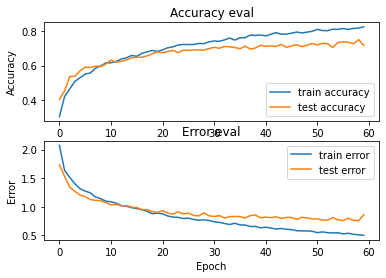

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 [==============================] - 2s 22ms/step - loss: 0.8002 - accuracy: 0.7317
Test accuracy: 0.7316780090332031


In [ ]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [ ]:
predict(model, X_test[15], y_test[15])

Expected index: 9, Predicted index: [9]


From this we can conclude that the accuracy has improved by a signifiant amount.

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://90da7e46-01a2-4578-846d-4cf5c48b9b4e/assets


In [ ]:
loaded_model = pickle.load(open("/content/finalized_model.sav", 'rb'))

In [ ]:
predict(loaded_model, X_test[10], y_test[10])

Expected index: 1, Predicted index: [1]
